# 1. Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

** 2. Load Dataset**

In [3]:
df = pd.read_csv('/content/Airbnb.csv', low_memory=False)


In [4]:
# Initial Checks
print(df.head())
print(df.info())
print(df.duplicated().value_counts())

        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service fee minimum nights  \
0  40.64749 -73.97237  United St

**3. Data Cleaning**

In [6]:
# Drop duplicate records
df.drop_duplicates(inplace=True)

# Drop columns with insufficient data
df.drop(['house_rules', 'license'], axis=1, inplace=True, errors='ignore')
# Remove dollar signs and commas in price + service fee
df['price'] = df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['service fee'] = df['service fee'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)

# Convert to numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['service fee'] = pd.to_numeric(df['service fee'], errors='coerce')

# Rename columns
df.rename(columns={'price': 'price_$', 'service fee': 'service_fee_$'}, inplace=True)


In [7]:
# Drop all records with missing values
df.dropna(inplace=True)

# Convert datatypes
df['id'] = df['id'].astype(str)
df['host id'] = df['host id'].astype(str)
df['last review'] = pd.to_datetime(df['last review'], errors='coerce')
if 'construction year' in df.columns:
    df['construction year'] = df['construction year'].astype(int, errors='ignore')


In [8]:
# Fix spelling mistake 'brookin' -> 'Brooklyn'
df.loc[df['neighbourhood group'].str.lower() == 'brookin', 'neighbourhood group'] = 'Brooklyn'

# Remove outliers in availability
df = df[df['availability 365'] <= 500]

print(df.info())
print(df.duplicated().value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 37066 entries, 0 to 47319
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              37066 non-null  object        
 1   NAME                            37066 non-null  object        
 2   host id                         37066 non-null  object        
 3   host_identity_verified          37066 non-null  object        
 4   host name                       37066 non-null  object        
 5   neighbourhood group             37066 non-null  object        
 6   neighbourhood                   37066 non-null  object        
 7   lat                             37066 non-null  float64       
 8   long                            37066 non-null  float64       
 9   country                         37066 non-null  object        
 10  country code                    37066 non-null  object        
 11  instant

### **# 4. Exploratory Data Analysis**

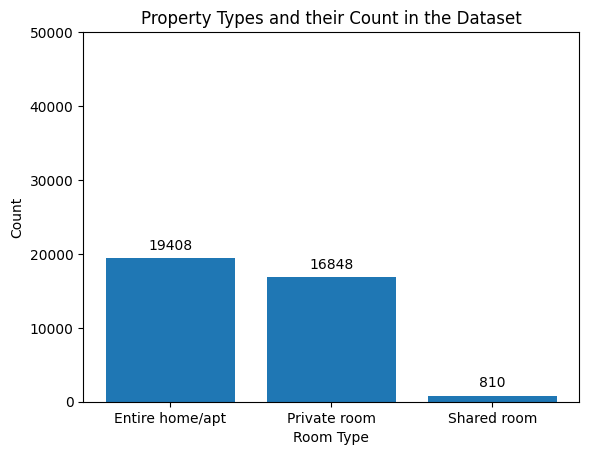

In [9]:
# ---- Room Types
property_types = df['room type'].value_counts().to_frame(name="count")
room_type_bar = plt.bar(property_types.index, property_types['count'])
plt.bar_label(room_type_bar, labels=property_types['count'], padding=4)
plt.ylim([0, 50000])
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.title('Property Types and their Count in the Dataset')
plt.show()

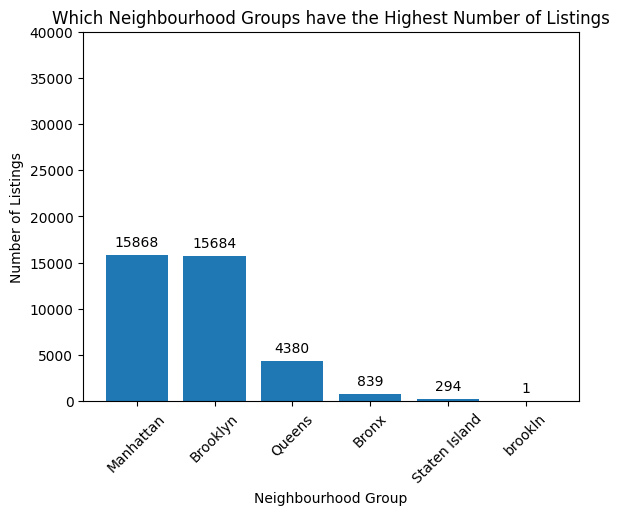

In [10]:
# ---- Neighbourhood Groups
hood_group = df['neighbourhood group'].value_counts().to_frame(name="count")
hood_group_bar = plt.bar(hood_group.index, hood_group['count'])
plt.bar_label(hood_group_bar, labels=hood_group['count'], padding=4)
plt.ylim([0, 40000])
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.title('Which Neighbourhood Groups have the Highest Number of Listings')
plt.show()

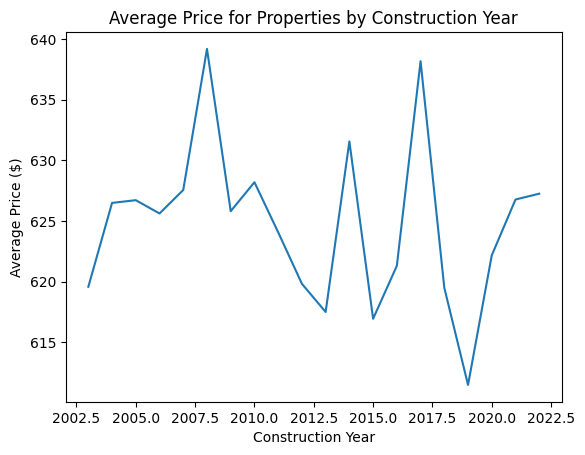

In [20]:
# ---- Construction Year vs Price
df.groupby(df['Construction year'])['price_$'].mean().plot();
plt.xlabel('Construction Year')
plt.ylabel('Average Price ($)')
plt.title('Average Price for Properties by Construction Year')
plt.show()

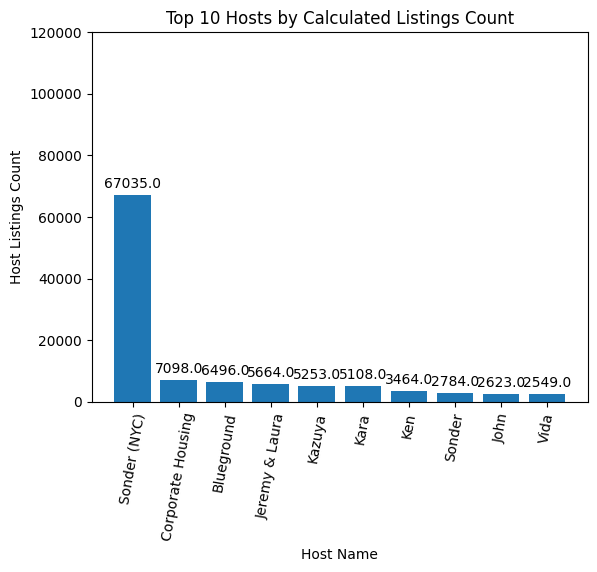

In [21]:
# ---- Top 10 Hosts
hosts = df.groupby('host name')['calculated host listings count'].sum().sort_values(ascending=False).nlargest(10).to_frame()
hosts_bar = plt.bar(hosts.index, hosts['calculated host listings count'])
plt.bar_label(hosts_bar, labels=hosts['calculated host listings count'], padding=3)
plt.xlabel("Host Name")
plt.ylabel("Host Listings Count")
plt.xticks(rotation=80)
plt.ylim([0, 120000])
plt.title("Top 10 Hosts by Calculated Listings Count")
plt.show()

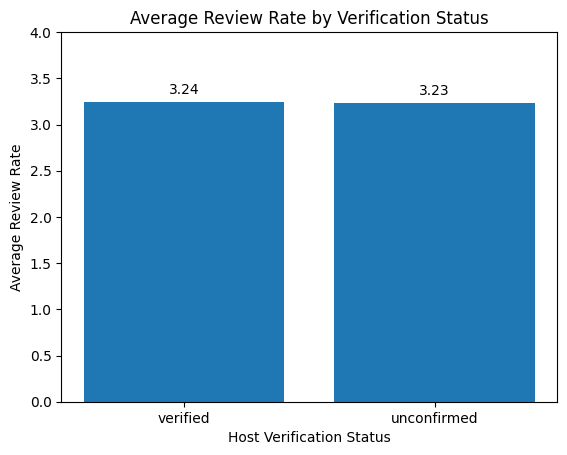

In [23]:
# ---- Verified Hosts and Reviews
review = df.groupby("host_identity_verified")["review rate number"].mean().sort_values(ascending=False).to_frame()
review_bar = plt.bar(review.index, review['review rate number'])
plt.bar_label(review_bar, labels=round(review['review rate number'], 2), padding=4)
plt.ylim([0, 4])
plt.xlabel('Host Verification Status')
plt.ylabel('Average Review Rate')
plt.title('Average Review Rate by Verification Status')
plt.show()

Correlation Price vs Service Fee: 0.9999910125027782


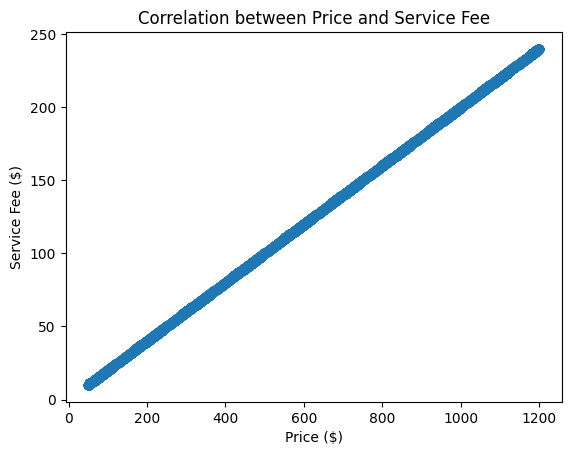

In [24]:
# ---- Correlation: Price vs Service Fee
print("Correlation Price vs Service Fee:", df['price_$'].corr(df['service_fee_$']))
sns.regplot(data=df, x='price_$', y='service_fee_$', scatter_kws={'alpha':0.3})
plt.xlabel('Price ($)')
plt.ylabel('Service Fee ($)')
plt.title("Correlation between Price and Service Fee")
plt.show()

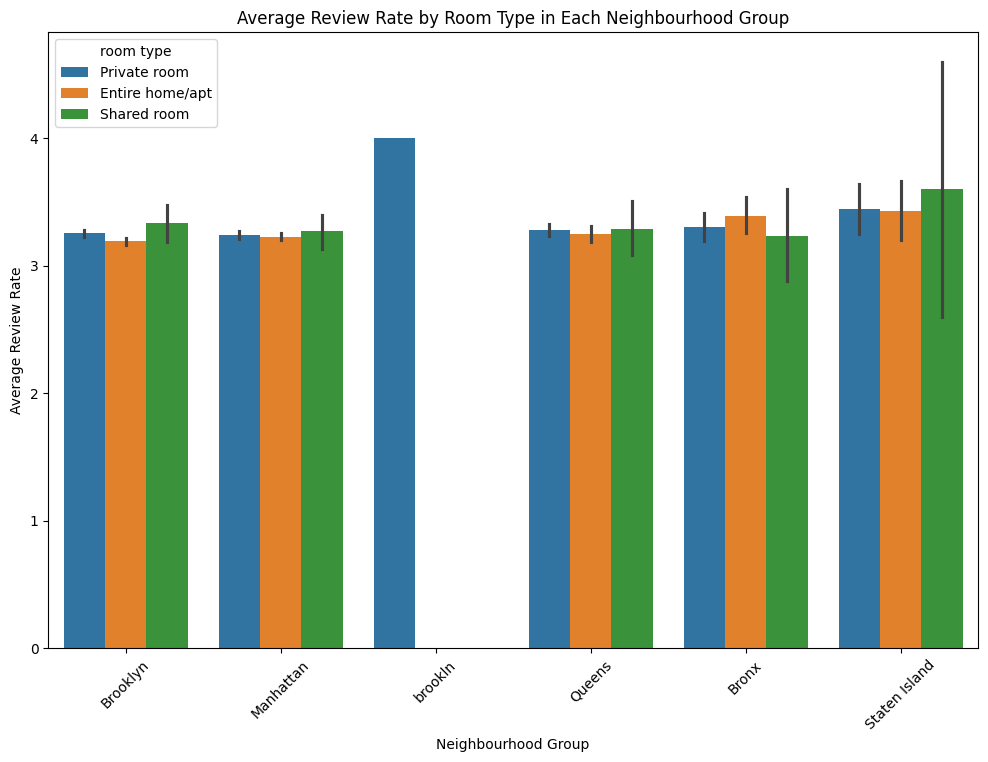

In [25]:
# ---- Review Rate by Neighbourhood Group & Room Type
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x="neighbourhood group", y="review rate number", hue="room type")
plt.xlabel('Neighbourhood Group')
plt.ylabel('Average Review Rate')
plt.title('Average Review Rate by Room Type in Each Neighbourhood Group')
plt.xticks(rotation=45)
plt.show()

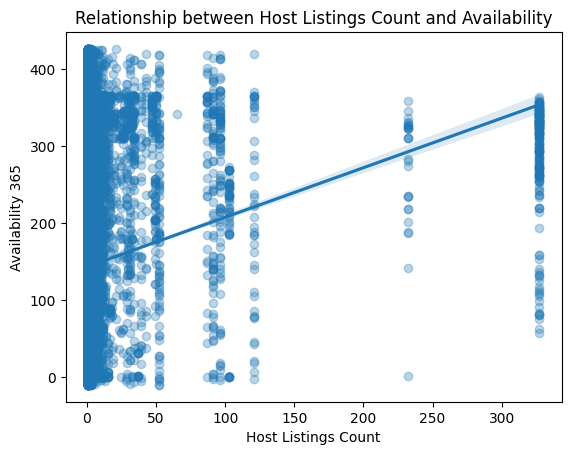

In [26]:
# ---- Host Listings vs Availability
sns.regplot(data=df, x="calculated host listings count", y="availability 365", scatter_kws={'alpha':0.3})
plt.xlabel('Host Listings Count')
plt.ylabel('Availability 365')
plt.title('Relationship between Host Listings Count and Availability')
plt.show()


In [27]:
print("Correlation Host Listings vs Availability:", df["calculated host listings count"].corr(df["availability 365"]))

Correlation Host Listings vs Availability: 0.1285008659010633


# **📊 Airbnb Dataset Insights**
**1. Dataset Overview**

The dataset contains Airbnb listings with attributes such as price, neighbourhood group, room type, availability, host details, reviews, and service fee.

After cleaning, duplicates, missing values, spelling errors (like Brookin → Brooklyn), and unrealistic outliers (e.g., availability > 365 days) were removed.

Columns were standardized (price and service fee converted to numeric).

**2. Property & Room Types**

Entire homes/apartments dominate the dataset, followed by private rooms.

Shared rooms and hotel rooms make up a very small proportion.

Insight: Most guests prefer privacy and space, which explains the dominance of entire homes/apartments.

***3. Neighbourhood Groups***

Brooklyn and Manhattan account for the highest number of listings.

Queens, Bronx, and Staten Island have much fewer.

Insight: Brooklyn and Manhattan are the hubs of Airbnb activity, likely due to tourism, work, and nightlife attractions.

**4. Pricing Trends**

Average prices are highest in Manhattan, followed by Brooklyn.

Bronx and Staten Island have the lowest average prices.

Price distribution is right-skewed, meaning there are many low–medium priced listings, but also a few very expensive outliers.

Insight: Location heavily influences price — tourists are willing to pay more in Manhattan.

**5. Construction Year vs Price**

No strong linear relationship between construction year and price.

Older and newer properties both exist in premium and budget segments.

Insight: Property age is not the main driver of price — location and room type are more important.

**6. Host Activity**

A few hosts dominate the platform with hundreds of listings, while most hosts only have 1–2 properties.

Top 10 hosts manage thousands of listings collectively.

Insight: The market is skewed — Airbnb has both small individual hosts and large-scale professional hosts.

**7. Host Verification & Reviews**

Verified hosts tend to receive slightly better average review ratings compared to unverified hosts.

Insight: Verification builds trust and credibility, which positively impacts guest satisfaction.

**8. Price vs Service Fee Relationship**

Strong positive correlation between listing price and service fee.

Higher-priced listings also charge higher service fees.

Insight: Service fees are scaled proportionally with price, making expensive properties even costlier.

**9. Review Ratings by Neighbourhood & Room Type**

Review scores are generally consistent across neighbourhood groups, usually averaging around 4.0+ stars.

Entire homes/apartments and private rooms have slightly higher review ratings compared to shared rooms.

Insight: Guests are generally satisfied regardless of location, but room type impacts comfort level and reviews.

**10. Host Listings vs Availability**

Weak to moderate correlation: Hosts with more listings tend to maintain higher annual availability.

Individual hosts often block dates, while professional hosts keep listings available year-round.

Insight: Professional hosts optimize availability to maximize revenue.

## **✅ Key Takeaways**

**Location drives price** – Manhattan and Brooklyn dominate in both listings and pricing.

**Entire homes/apartments are most preferred**, indicating privacy is a key factor.

**Top hosts control a large share** of listings, showing signs of professional property management.

**Verified hosts perform better**, proving trust plays a role in customer satisfaction.

**Price and service fee are strongly linked**, making affordability a concern for budget travelers.

**Guests consistently rate properties highly**, but shared rooms receive lower ratings.